In [1]:
# Import libraries here
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Import

Write a `wrangle` function that will use the query to create a DataFrame

In [2]:
# Build your `wrangle` function here
def wrangle(path):
    # Connect to database using connect method
    conn = sqlite3.connect(path)
    
    # Construct query
    query = """SELECT distinct(i.building_id) AS b_id, s.*, d.damage_grade
            FROM id_map AS i
            JOIN building_structure AS s ON i.building_id = s.building_id
            JOIN building_damage AS d ON i.building_id = d.building_id
            WHERE district_id = 3"""
    
    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Create binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicolinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high categorical features
    drop_cols.append("building_id")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [3]:
df = wrangle("../data/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


## Explore

Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column.

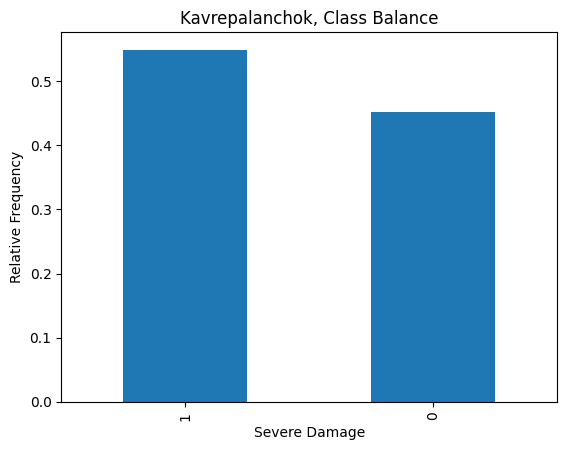

In [4]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Severe Damage", ylabel="Relative Frequency", title="Kavrepalanchok, Class Balance"
);

Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? 

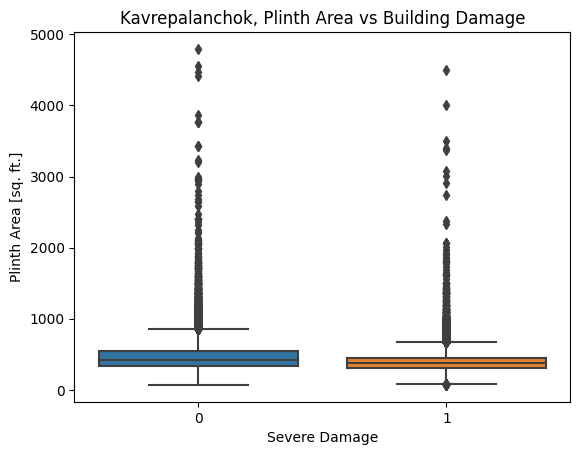

In [5]:
# Use seaborn to create a boxplot that shows the distributions of the "plinth_area_sq_ft" column for both groups in the "severe_damage" column.
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df)
# Label axes
plt.xlabel('Severe Damage')
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

Are buildings with certain roof types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [6]:
roof_pivot = pd.pivot_table(
    df, index="roof_type", values="severe_damage", aggfunc=np.mean
)
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842
RCC/RB/RBC,0.040715


## Split

Create feature matrix `X` and target vector `y`. target is `"severe_damage"`.

In [7]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


Divide dataset into training and validation sets using a randomized split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

Calculate the baseline accuracy score for your model.

In [9]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

Create a model `model_lr` that uses logistic regression to predict building damage.

In [10]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=2000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

Calculate training and validation accuracy score for `model_lr`. X_train

In [11]:
lr_train_acc = accuracy_score(y_train, model_lr.predict(X_train))
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", round(lr_train_acc, 4))
print("Logistic Regression, Validation Accuracy Score:", round(lr_val_acc, 4))

Logistic Regression, Training Accuracy Score: 0.6515
Logistic Regression, Validation Accuracy Score: 0.6518


Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_dt` at all depths from 1 to 15.

In [ ]:
depth_hyperparams = range(1, 16)    # for max_depth
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth= d, random_state=42)
    )
    # Fit model to training data
    model_dt.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(model_dt.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(model_dt.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:6])
print("Validation Accuracy Scores:", validation_acc[:6])

model_dt.fit(X_train, y_train)

Using the values in `training_acc` and `validation_acc`, plot the validation curve for `model_dt`.

In [ ]:
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [ ]:
final_model_dt = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth= 10 , random_state=42)
)
final_model_dt.fit(X_train, y_train)

## EvaluateX_train

How does my model perform on the test set? First, read the CSV file `"data/kavrepalanchok-test-features.csv"` into the DataFrame `X_test`. Next, use `final_model_dt` to generate a list of test predictions `y_test_pred`.

In [ ]:
X_test = pd.read_csv("../data/kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = pd.Series(final_model_dt.predict(X_test))
y_test_pred[:5]

# Communicate Results

What are the most important features for `final_model_dt`? Create a Series Gini `feat_imp`, where the index labels are the feature names for your dataset and the values are the feature importances for your model.

In [ ]:
features = X_train.columns
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

Create a horizontal bar chart of `feat_imp`.

In [ ]:
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");